    2.1 Анализ перередвижения людей мнежду зонами в городе.

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# Воспользуемся итератором для чтения csv
iterator_matrix = pd.read_csv('matrix.csv', iterator=True, delimiter=';')

In [3]:
chunk_size = 15_000_000
chunks = []
while True:
    try:
        chunk = iterator_matrix.get_chunk(chunk_size)
        chunks.append(chunk)
    except StopIteration:
        print('stop iteration')
        break

stop iteration


In [4]:
# Соединим данные в один дата фрейм
df = pd.concat(chunks)
df.columns = ['time', 'depart', 'arrival', 'customers', 'customers_metro']
df['time'] = pd.to_datetime(df['time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191345852 entries, 0 to 191345851
Data columns (total 5 columns):
 #   Column           Dtype         
---  ------           -----         
 0   time             datetime64[ns]
 1   depart           int64         
 2   arrival          int64         
 3   customers        int64         
 4   customers_metro  int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 7.1 GB


In [5]:
# df['range_hour'] = df['time'].apply(lambda x: x.hour + x.minute)
df['range_hour'] = df['time'].dt.time
df['range_day'] = df['time'].dt.dayofweek
df['customers'] = df['customers'] + df['customers_metro']
df.drop('customers_metro', axis=1, inplace=True)

    Найдем суммарное количество трансферов между зонами в получасовые интервалы за все буднии дни.

In [6]:
total_transfer_weekday = df.query('range_day not in [5, 6]'
                                  ).groupby(['range_hour'], as_index=False
                                   ).agg({'customers': 'sum'})

<AxesSubplot:title={'center':'Количество передвижений пассажиров в городе в будний день'}, ylabel='range_hour'>

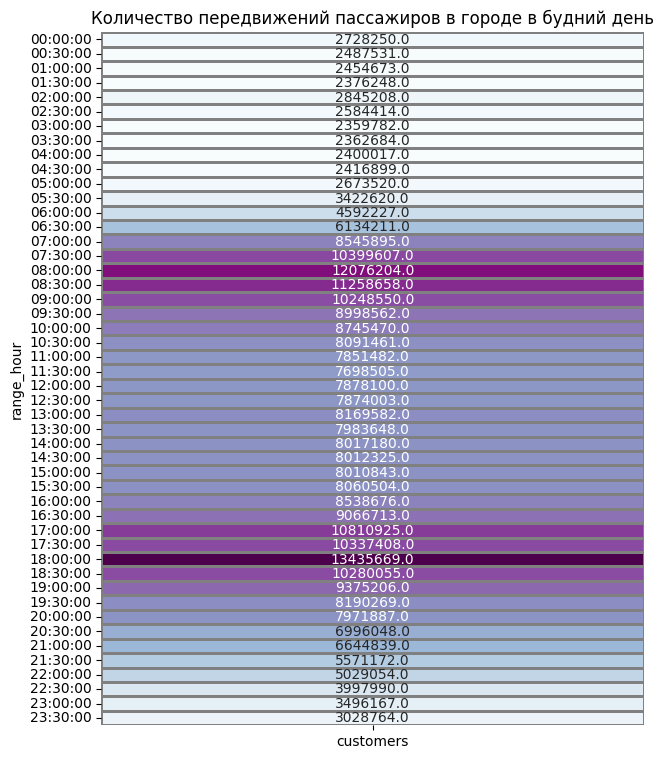

In [10]:
plt.figure(figsize=(7, 10))
plt.title('Количество передвижений пассажиров в городе в будний день')
sns.heatmap(total_transfer_weekday.pivot_table(index = 'range_hour', values='customers',
                                               aggfunc='sum'), annot=True, cbar=False,
                                               fmt='.1f', cmap="BuPu",
                                               linewidths=2, linecolor='gray')

Из данного графика можно выделить интервалы с пиковой нагрузкой на транспортную инфраструктуру на интервалах с 8.00 до 9.00 утром и с 18.00 до 18.30 вечером.

In [11]:
# Суммарное количество отправлений из каждой зоны по временным интервалам
total_depart = df.query('range_day not in [5, 6]'
                        ).groupby(['range_hour', 'depart'], as_index=False
                                  ).agg({'customers': 'sum'})
total_depart.head()

,range_hour,depart,customers
0,00:00:00,1,481
1,00:00:00,2,8085
2,00:00:00,3,877
3,00:00:00,4,409
4,00:00:00,6,2271


In [12]:
# Суммарное количество прибытий в каждую зону, исключив дублирование данных о передвижениях внутри зоны
total_arrival = df.query('range_day not in [5, 6] & "depart" != "arrival"'
                         ).groupby(['range_hour', 'arrival'], as_index=False
                                   ).agg({'customers': 'sum'})

total_arrival.head()

,range_hour,arrival,customers
0,00:00:00,1,622
1,00:00:00,2,4446
2,00:00:00,3,888
3,00:00:00,4,566
4,00:00:00,6,1211


In [13]:
# Соединим данные отправлений и прибытий по номеру зоны
total_transfers = total_depart.merge(total_arrival,
                       left_on=['depart', 'range_hour'], right_on=['arrival', 'range_hour'],
                       how='outer', suffixes=('_dep','_arr'))

total_transfers['location'] = total_transfers['depart'].fillna(0).astype(int)
total_transfers['customers_dep'] = total_transfers['customers_dep'].fillna(0).astype(int)

total_transfers.head()

,range_hour,depart,customers_dep,arrival,customers_arr,location
0,00:00:00,1.0,481,1,622,1
1,00:00:00,2.0,8085,2,4446,2
2,00:00:00,3.0,877,3,888,3
3,00:00:00,4.0,409,4,566,4
4,00:00:00,6.0,2271,6,1211,6


In [14]:
# Получим суммарное значение передвижений через каждую зону в каждый интервал времени (получасовые)
total_transfers['customers'] = total_transfers['customers_arr'] + total_transfers['customers_dep']

total_transfers.drop('depart', axis=1, inplace=True)
total_transfers.drop('arrival', axis=1, inplace=True)
total_transfers.drop('customers_arr', axis=1, inplace=True)
total_transfers.drop('customers_dep', axis=1, inplace=True)

total_transfers.head()

,range_hour,location,customers
0,00:00:00,1,1103
1,00:00:00,2,12531
2,00:00:00,3,1765
3,00:00:00,4,975
4,00:00:00,6,3482


In [15]:
# Найдем максимальные значения трансфера для каждой зоны в рамках временного интервала
total_peacks = total_transfers.groupby(['location'], as_index=False
                                  ).agg({'customers': 'max'})

total_peacks.head()

,location,customers
0,0,3
1,1,3210
2,2,37440
3,3,5629
4,4,7469


In [25]:
# Для каждой зоны выберем временные интервалы в которые трансфер превышает пороговое значение
# Сделано допущение, что пиковая нагрузка - топ 10% от максимальной
total_locations_peacks = total_transfers.merge(total_peacks,
                                             suffixes=('','_max'),
                                             left_on=['location'],
                                             right_on=['location'],
                                             how='inner').query('customers > customers_max * 0.9')
# Обновим значения индексов
total_locations_peacks.reset_index(drop=True, inplace=True)
total_locations_peacks.head()

,range_hour,location,customers,customers_max
0,07:30:00,1,2935,3210
1,08:00:00,1,3006,3210
2,08:30:00,1,3030,3210
3,09:30:00,1,2903,3210
4,16:30:00,1,3210,3210


Добавим возможность отображения пиковых интервалов для любой выбранной зоны.

<AxesSubplot:title={'center':'Пиковые интервалы нагрузки для зоны: 68'}, ylabel='range_hour'>

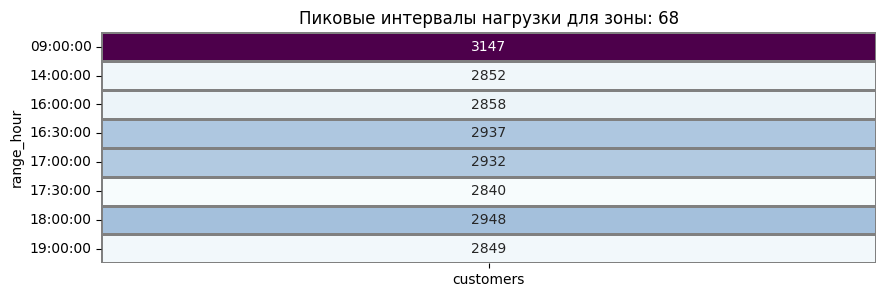

In [17]:
location = 68
plt.figure(figsize=(10, 3))
plt.title(f'Пиковые интервалы нагрузки для зоны: {location}')
sns.heatmap(total_locations_peacks.query(
    f'location == {location}').pivot_table(index = 'range_hour', values='customers',
                                           aggfunc='sum'), annot=True, cbar=False,
                                           fmt='d', cmap="BuPu",
                                           linewidths=1, linecolor='gray')

Тепловая карта пиковой нагрузки каждой зоны дополнительно позволяет визуализировать данные.

    2.2 Найдем суммарное количество трансферов между зонами в получасовые интервалы по каждому буднему дню.

In [18]:
total_transfer = df.query('range_day not in [5, 6]'
                          ).groupby(['range_day', 'range_hour'], as_index=False
                                    ).agg({'customers': 'sum'})

In [19]:
total_transfer.head()

,range_day,range_hour,customers
0,0,00:00:00,466043
1,0,00:30:00,408533
2,0,01:00:00,376791
3,0,01:30:00,369198
4,0,02:00:00,378936


    Построим тепловой график нагрузки на транспортную инфраструктуру города в разбивке по будним дням недели.

<AxesSubplot:title={'center':'Количество передвижений пассажиров в городе по дням недели'}, xlabel='range_day', ylabel='range_hour'>

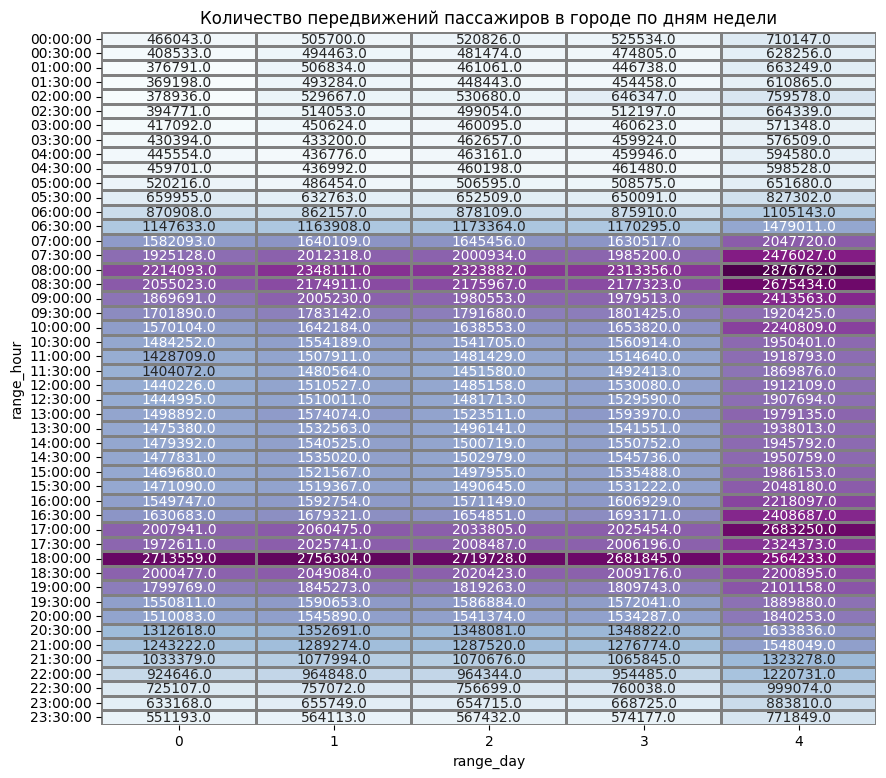

In [20]:
plt.figure(figsize=(10, 9))
plt.title('Количество передвижений пассажиров в городе по дням недели')
sns.heatmap(total_transfer.pivot_table(index = 'range_hour',
                                       columns='range_day', values='customers',
                                       aggfunc='sum'), annot=True, fmt='.1f', cbar=False, cmap="BuPu",
                                       linewidths=2, linecolor='gray')

Из графика видно, что с понедельника по четверг самый высокий трафик приходится на интервалы с 8.00 до 8.30 утром и с 18.00 до 18.30 вечером. В пятницу картина не так однозначна: во первых утренний и вечерний пик существенно выше по сравнению с другими днями, во вторых вечерний пик в дополнение к "стандартному" интервалу с 18.00 до 18.30 имеет дополнительную вершину на интервале с 17.00 до 17.30, что связано с тем что во многих организациях пятница - короткий день.

В отличии от графика количества передвижений пассажиров в городе в будний день, на данном графике можно увидеть потребность в корректировке режимов работы транспортной инфраструктуры по пятницам.